In [33]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from decimal import Decimal


In [26]:
%matplotlib inline

In [37]:
### Please note the small difference of the function for each script
def generate_taxonomy_pivot_wimp(tax_df, rank, bcs, num):
    """From tax_df, generate a pivot table listing num rank counts, sorted by bcs"""
    pivot_table = tax_df.pivot_table(values='seqlen_wimp', 
                                            index=rank, 
                                            columns='barcode_wimp', 
                                            aggfunc='sum', 
                                            fill_value=0)
    pivot_table.columns.name = None
    pivot_table = pivot_table.sort_values(bcs, axis=0, ascending=False).head(n=num)
    return pivot_table


#count pivot table of dataframe with taxonomic columns: 
#rows - rank names, columns - barcode, sorted by desired class
def generate_taxonomy_pivot_blast(tax_df, rank, bcs, num):
    """From tax_df, generate a pivot table listing num rank counts, sorted by bcs"""
    pivot_table = tax_df.pivot_table(values='sequence_length_template_blast', 
                                            index=rank, 
                                            columns='barcode_arrangement_blast', 
                                            aggfunc='sum', 
                                            fill_value=0)
    pivot_table.columns.name = None
    pivot_table = pivot_table.sort_values(bcs, axis=0, ascending=False).head(n=num)
    return pivot_table

In [28]:
# put in all input path and load the final_df
basedir = '/home/yiheng/data/20181118_FAH84398'
barcode = '08'
final_df = pd.read_csv(os.path.join(basedir, 'analysis', 'final_df.barcode%s.csv' % barcode), sep='\t')

/home/yiheng/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
# sort out the information from WIMP taxa
unclassified_reads_wimp = final_df[final_df.exit_status_wimp == 'Unclassified']
human_reads_wimp = final_df[final_df.species_wimp == 'Homo sapiens']
mammal_reads_wimp = final_df[(final_df.class_wimp == 'Mammalia') & (final_df.species_wimp != 'Homo sapiens')]
microbe_reads_wimp = final_df[(final_df.species_wimp != 'Homo sapiens') & (final_df.exit_status_wimp == 'Classified')]
total_length_wimp = sum(final_df.seqlen_wimp)
unclassified_reads_wimp_proportion = sum(unclassified_reads_wimp.seqlen_wimp)/total_length_wimp*100
human_reads_wimp_proportion = sum(human_reads_wimp.seqlen_wimp)/total_length_wimp*100
mammal_reads_wimp_proportion = sum(mammal_reads_wimp.seqlen_wimp)/total_length_wimp*100
microbe_reads_wimp_proportion = sum(microbe_reads_wimp.seqlen_wimp)/total_length_wimp*100
column_name = 'barcode%s' % barcode
wimphit_df = pd.DataFrame([unclassified_reads_wimp_proportion, human_reads_wimp_proportion, mammal_reads_wimp_proportion, microbe_reads_wimp_proportion])
wimphit_df.columns = [column_name]

In [30]:
# sort out the information from BLAST taxa
unclassified_reads_blast = final_df[final_df.species_blast == 'Unclassified']
human_reads_blast = final_df[final_df.species_blast == 'Homo sapiens']
mammal_reads_blast = final_df[(final_df.class_blast == 'Mammalia') & (final_df.species_blast != 'Homo sapiens')]
no_mammal_reads_blast = final_df[(final_df.class_blast != 'Mammalia') & (final_df.class_blast != 'Unclassified')]
total_length_blast = sum(final_df.sequence_length_template_blast)
unclassified_reads_blast_proportion = sum(unclassified_reads_blast.sequence_length_template_blast)/total_length_blast*100
human_reads_blast_proportion = sum(human_reads_blast.sequence_length_template_blast)/total_length_blast*100
mammal_reads_blast_proportion = sum(mammal_reads_blast.sequence_length_template_blast)/total_length_blast*100
microbe_reads_blast_proportion = sum(no_mammal_reads_blast.sequence_length_template_blast)/total_length_blast*100
column_name = 'barcode%s' % barcode
blasthit_df = pd.DataFrame([unclassified_reads_blast_proportion, human_reads_blast_proportion,mammal_reads_blast_proportion, microbe_reads_blast_proportion])
blasthit_df.columns = [column_name]

In [31]:
hit_df = pd.concat([wimphit_df, blasthit_df], axis=1).T

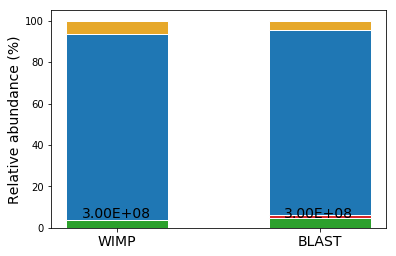

In [32]:
# plot subfigure for supplementary figure S1
def get_color(x):
    x = x%10
    return ('#%02X%02X%02X' % (int(plt.cm.tab10.colors[x][0]*255),int(plt.cm.tab10.colors[x][1]*255),int(plt.cm.tab10.colors[x][2]*255)))

barWidth = 1
r = [0,2]
plt.bar(r, hit_df[3], label = 'microbe reads', color=get_color(2), edgecolor='white', width=barWidth)
plt.bar(r, hit_df[2], label = 'mammal reads other than human', bottom=hit_df[3], color=get_color(3), edgecolor='white', width=barWidth)
plt.bar(r, hit_df[1], label = 'human reads', bottom=[i+j for i,j in zip(hit_df[3], hit_df[2])], color=get_color(10), edgecolor='white', width=barWidth)
plt.bar(r, hit_df[0], label = 'unclassified reads', bottom=[i+j+k for i,j,k in zip(hit_df[3], hit_df[2], hit_df[1])], color='#E6A82A', edgecolor='white', width=barWidth)

plt.xticks(r, ['WIMP', 'BLAST'], fontsize=14)
WIMP_text = '%.2E' % Decimal(sum(final_df.seqlen_wimp))
blast_text = '%.2E' % Decimal(sum(final_df.sequence_length_template_blast))

plt.text(-0.35, 5, WIMP_text, fontsize=14)
plt.text(1.65, 5, blast_text, fontsize=14)

plt.ylabel("Relative abundance (%)", fontsize=14)

plt.savefig('/home/yiheng/analysis/clinical_WGS/Pneumocystis/barcode%s_hits.svg' % barcode, bbox_inches='tight', dpi=600)
plt.show()

In [49]:
### Now start plotting figure 3 and supplementary figure S2 using floweaver
from floweaver import *

In [57]:
trimed_final_df = final_df.drop(columns=['bitscore_blast', 'length_blast', 'passes_filtering_blast', 'pident_blast', 'read_id_blast', 'mean_qscore_wimp',
                                         'taxID_wimp', 'staxids_blast', 'score_wimp', 'mean_qscore_template_blast',
                                        'send_blast', 'sstart_blast', 'sseqid_blast', 'coverage_blast', 'nident_blast'])
fungal_phylums = ['Blastocladiomycota', 'Chytridiomycota', 'Glomeromycota', 'Microsporidia', 
                  'Neocallimastigomycota', 'Ascomycota', 'Basidiomycota', 'Mucoromycota']
fungal_final_df = trimed_final_df[trimed_final_df.phylum_blast.isin(fungal_phylums) |
                                  trimed_final_df.phylum_wimp.isin(fungal_phylums)]
# columns required for Sankey graph
fungal_final_df['source'] = fungal_final_df.phylum_blast
fungal_final_df['target'] = fungal_final_df.phylum_wimp
fungal_final_df['value'] = fungal_final_df.seqlen_wimp


### this overlapped df was used for providing information for table 2
overlapped_fungal_df = fungal_final_df[(fungal_final_df.source.isin(fungal_phylums)) & (fungal_final_df.target.isin(fungal_phylums))]

/home/yiheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/yiheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/yiheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [61]:
final_WIMP_df_fungi_pivot = generate_taxonomy_pivot_wimp(fungal_final_df, 'phylum_wimp', 'barcode%s' % barcode, 30)
# this is used to mannual copy the 'others' portion of Sankey graph
final_WIMP_df_fungi_pivot.index

Index(['Ascomycota', 'Basidiomycota', 'Mucoromycota', 'Chytridiomycota',
       'Unclassified', 'Microsporidia', 'Chordata'],
      dtype='object', name='phylum_wimp')

In [60]:
final_blast_df_fungi_pivot = generate_taxonomy_pivot_blast(fungal_final_df, 'phylum_blast', 'barcode%s' % barcode, 30)
# this is used to mannual copy the 'others' portion of Sankey graph
final_blast_df_fungi_pivot.index

Index(['Chordata', 'Unclassified', 'Firmicutes', 'Actinobacteria',
       'Ascomycota', 'Bacteroidetes', 'Platyhelminthes', 'Nematoda',
       'Streptophyta', 'Fusobacteria'],
      dtype='object', name='phylum_blast')

In [59]:
fungi_dataset = Dataset(fungal_final_df)

In [62]:
###Check the hard code!!!

nodes = {
    'phylum_blast': ProcessGroup(fungal_final_df.phylum_blast.tolist()),
    'phylum_wimp': ProcessGroup(fungal_final_df.phylum_wimp.tolist()),
}

ordering = [
    ['phylum_blast'],       # put "farms" on the left...
    ['phylum_wimp']   # ... and "customers" on the right.
]
bundles = [
    Bundle('phylum_blast', 'phylum_wimp')
]
sdd = SankeyDefinition(nodes, bundles, ordering)

blast_phylums_with_other = Partition.Simple('process', [
     'Unclassified', ('Fungi', ['Ascomycota']),
    ('Non-fungi', ['Chordata', 'Firmicutes', 'Actinobacteria',
     'Bacteroidetes', 'Platyhelminthes', 'Nematoda',
     'Streptophyta', 'Fusobacteria'])])   # ... or a group

wimp_phylums_with_other = Partition.Simple('process', [
    'Unclassified',('Fungi', ['Ascomycota', 'Basidiomycota', 'Mucoromycota', 'Chytridiomycota',
      'Microsporidia']),
    ('Non-fungi', ['Chordata']) # ... or a group
])

In [63]:
nodes['phylum_blast'].partition = blast_phylums_with_other
nodes['phylum_wimp'].partition = wimp_phylums_with_other

In [64]:
size = dict(width=360, height=200)
weave(sdd, fungi_dataset).to_widget(**size).auto_save_svg('/home/yiheng/analysis/clinical_WGS/Pneumocystis/barcode%s_fungi_sankey.svg' % barcode)

SankeyWidget(groups=[{'id': 'phylum_blast', 'type': 'process', 'title': '', 'nodes': ['phylum_blast^Unclassifi…

In [83]:
# now plotting subfigure for supplementary figure S2
bacteria_final_df = trimed_final_df[(trimed_final_df.superkingdom_blast == 'Bacteria') 
                                    | (trimed_final_df.superkingdom_wimp == 'Bacteria')]
bacteria_final_df['source'] = bacteria_final_df.superkingdom_blast
bacteria_final_df['target'] = bacteria_final_df.superkingdom_wimp
bacteria_final_df['value'] = bacteria_final_df.seqlen_wimp

/home/yiheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/yiheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/yiheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [84]:
final_WIMP_df_bacteria_pivot = generate_taxonomy_pivot_wimp(bacteria_final_df, 'superkingdom_wimp', 'barcode%s' % barcode, 30)
final_WIMP_df_bacteria_pivot.index

Index(['Bacteria', 'Unclassified', 'Eukaryota'], dtype='object', name='superkingdom_wimp')

In [85]:
final_blast_df_bacteria_pivot = generate_taxonomy_pivot_blast(bacteria_final_df, 'superkingdom_blast', 'barcode%s' % barcode, 30)
final_blast_df_bacteria_pivot.index

Index(['Bacteria', 'Unclassified', 'Eukaryota', 'Viruses'], dtype='object', name='superkingdom_blast')

In [86]:
bacteria_dataset = Dataset(bacteria_final_df)

In [87]:
### mannual check the hard code from the indexes above
nodes = {
    'superkingdom_blast': ProcessGroup(bacteria_final_df.superkingdom_blast.tolist()),
    'superkingdom_wimp': ProcessGroup(bacteria_final_df.superkingdom_wimp.tolist()),
}

ordering = [
    ['superkingdom_blast'],       # put "farms" on the left...
    ['superkingdom_wimp']   # ... and "customers" on the right.
]
bundles = [
    Bundle('superkingdom_blast', 'superkingdom_wimp')
]
sdd = SankeyDefinition(nodes, bundles, ordering)

blast_superkingdom_with_other = Partition.Simple('process', [
     'Unclassified', 'Bacteria',
    ('Non-bacteria', ['Eukaryota', 'Viruses'])])   # ... or a group

wimp_superkingdom_with_other = Partition.Simple('process', [
    'Unclassified', 'Bacteria',
    ('Non-bacteria', ['Eukaryota']) # ... or a group
])

In [88]:
nodes['superkingdom_blast'].partition = blast_superkingdom_with_other
nodes['superkingdom_wimp'].partition = wimp_superkingdom_with_other

In [89]:
size = dict(width=360, height=200)
weave(sdd, bacteria_dataset).to_widget(**size).auto_save_svg('/home/yiheng/analysis/clinical_WGS/Pneumocystis/barcode%s_bacteria_sankey.svg' % barcode)

SankeyWidget(groups=[{'id': 'superkingdom_blast', 'type': 'process', 'title': '', 'nodes': ['superkingdom_blas…